<p style='font-family: times, serif; font-size:25pt; font-style:bold; color:white;'>
    SHyTCWaves - Application for bulk parameters
</p>

<p style='font-family: times, serif; font-size:16pt; font-style:bold; color:white;'>
    TC - historical tracks
</p>

<hr size="5"/>

<div class="alert-warning">
<b>Info:</b> Here SHyTCWaves runs for the defined track and in the area defined below
</div>

<style>
.alert-warning {
    background-color: #ffcccb; /* Color de fondo rojito claro */
    color: #8b0000; /* Color del texto rojo oscuro */
    padding: 10px;
    border-radius: 5px;
    border: 1px solid #f08080; /* Borde rojo claro */
}
</style>

In [1]:
import warnings

warnings.filterwarnings("ignore")

# common
import os
import os.path as op
import time

# pip
import numpy as np
import xarray as xr

# shytcwaves
from bluemath_tk.tcs.tracks import check_storm_data, resample_storm_6h
from bluemath_tk.tcs.shytcwaves import historic2shytcwaves_cluster
from utils.plotting import plot_storm_track, plot_swath_shytcwaves, plot_hs_tp_point

###  **1. Load data**

<div class="alert-warning">
<b>Info:</b> Here SHyTCWaves runs for the defined track and in the area defined below
</div>

<style>
.alert-warning {
    background-color: #fffacd; /* Color de fondo amarillito más oscuro */
    color: #8b8000; /* Color del texto amarillo oscuro */
    padding: 10px;
    border-radius: 5px;
    border: 1px solid #f0e68c; /* Borde amarillo oscuro */
}
</style>

In [12]:
# IBTrACS
p_tracks = "/lustre/geocean/DATA/GEOOCEAN/IBTrACS.ALL.v04r00.nc"  # If this changes, it also needs to be modified in storms.py
xds_tcs = xr.open_dataset(p_tracks)

# SHyTCWaves
path_library = "/lustre/geocean/DATA/GEOOCEAN/SHyTCWaves_bulk/"  # Path to folder in which "library_shytcwaves_bulk_params.nc" is
path_mda = (
    "/home/grupos/geocean/tausiaj/BlueMath_tk/shytcAlba/data_shytcwaves/library_mda"
)

In [13]:
output_folder_name = "outputs"
output_path = op.join(os.getcwd(), output_folder_name)
os.makedirs(output_path, exist_ok=True)

###  **2. Storm selection**

<div class="alert-warning">
<b>Info:</b> Here SHyTCWaves runs for the defined track and in the area defined below
</div>

<style>
.alert-warning {
    background-color: #d3d3e6; /* Color de fondo azul más seco y clarito */
    color: #00008b; /* Color del texto azul oscuro */
    padding: 10px;
    border-radius: 5px;
    border: 1px solid #b0c4de; /* Borde azul acero claro */
}
</style>

The track can be selected by:
- Position 
- Name and year

In [14]:
# to select tc from id
# itc = 10000

In [15]:
# to select tc from name and year
name_tc, year_tc = "KATRINA", 2005
itc = np.where(
    (xds_tcs["name"].values.astype("str") == name_tc)
    & (xds_tcs.isel(date_time=0).time.dt.year.values == year_tc)
)[0]
storm = xds_tcs.isel(storm=itc).squeeze()
storm

<xarray.Dataset> Size: 264kB
Dimensions:           (date_time: 360, quadrant: 4)
Coordinates:
    time              (date_time) datetime64[ns] 3kB ...
    lat               (date_time) float32 1kB ...
    lon               (date_time) float32 1kB ...
Dimensions without coordinates: date_time, quadrant
Data variables: (12/147)
    numobs            float32 4B ...
    sid               |S13 13B ...
    season            float32 4B ...
    number            int16 2B ...
    basin             (date_time) |S2 720B ...
    subbasin          (date_time) |S2 720B ...
    ...                ...
    reunion_gust      (date_time) float32 1kB ...
    reunion_gust_per  (date_time) float32 1kB ...
    usa_seahgt        (date_time) float32 1kB ...
    usa_searad        (date_time, quadrant) float32 6kB ...
    storm_speed       (date_time) float32 1kB ...
    storm_dir         (date_time) float32 1kB ...
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

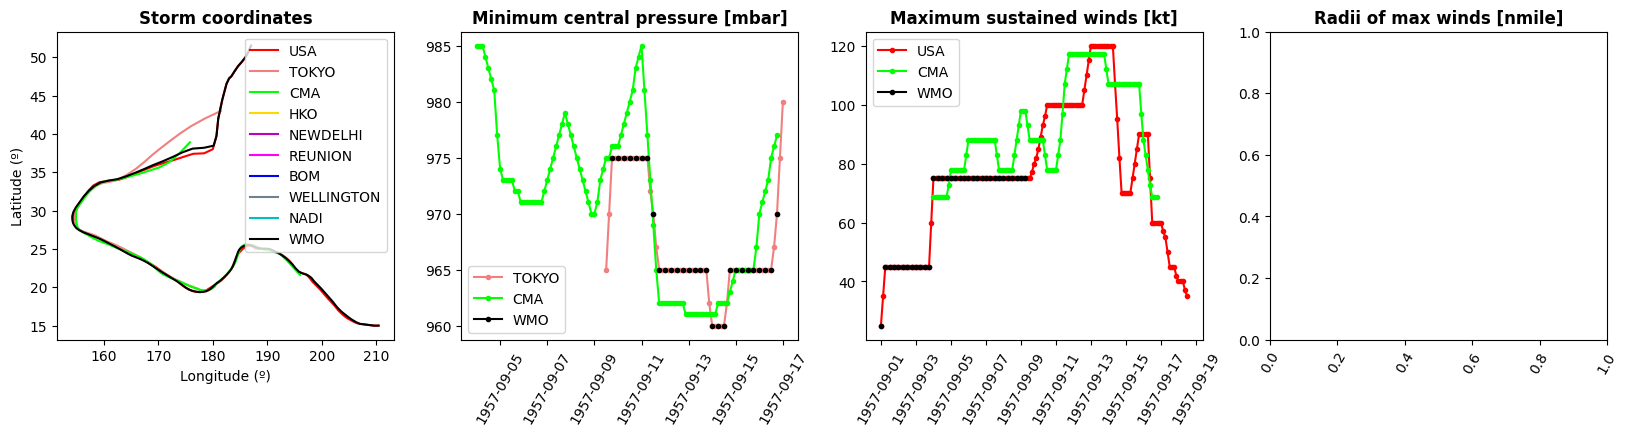

In [22]:
storm = xr.open_dataset("outputs/ibtracs_oahu.nc").isel(storm=1)
storm_year = int(storm.season.values)

name = str(storm.name.values)[2:-1]
year = storm.time[0].dt.year.values

# plot IBTrACS data
plt = check_storm_data(storm)

In [23]:
# NOTE
# resample to 6H
# it may be necessary only for some tracks

storm = resample_storm_6h(storm)
storm["lon"] = (
    ("time"),
    np.where(storm["lon"].values < 0, storm["lon"].values + 360, storm["lon"].values),
)

###  **3. SHyTCWaves**

<div class="alert-warning">
<b>Info:</b> Here SHyTCWaves runs for the defined track and in the area defined below
</div>

<style>
.alert-warning {
    background-color: #f0fff0; /* Color de fondo verdecito muy claro */
    color: #006400; /* Color del texto verde oscuro */
    padding: 10px;
    border-radius: 5px;
    border: 1px solid #98fb98; /* Borde verde claro */
}
</style>

In [24]:
# Are sourrounding storm to extract bulk parameters
extra_area = 12
area = [
    storm.lon.min().values - extra_area,
    storm.lon.max().values + extra_area,
    storm.lat.min().values - extra_area,
    storm.lat.max().values + extra_area,
]

In [25]:
t0 = time.time()

# project path
path_proj = op.join(output_path, "tc_{0}_{1}_{2}".format(itc, name, year))
if not op.isdir(path_proj):
    os.mkdir(path_proj)

tc_name = name + "_hist"
center = "WMO"

swath_resolution = 0.5
lon = np.arange(area[0], area[1], swath_resolution)
lat = np.arange(area[2], area[3], swath_resolution)

historic2shytcwaves_cluster(
    path_proj,
    path_mda,
    path_library,
    tc_name,
    storm,
    center,
    lon,
    lat,
    calibration=True,
    extract_bulk=True,
)

print(f"Elapsed time: {time.time() - t0} s")

WMO
27
st: 27 df_seg: 26
Number of segments: 24, number of swath nodes: 8256
Merging bulk envelope... 2025-05-12 16:47:12.671420
Files stored.

Elapsed time: 253.99034357070923 s


###  **4. Plotting**

<div class="alert-warning">
<b>Info:</b> Plotting results - Maps and timeseries
</div>

<style>
.alert-warning {
    background-color: #e6e6fa; 
    color: #4b0082; /* text */
    padding: 10px;
    border-radius: 5px;
    border: 1px solid #dda0dd; 
}
</style>

In [26]:
# Load results
xds_bulk = xr.open_dataset(op.join(path_proj, "{0}_xds_shy_bulk.nc".format(tc_name)))

<div class="alert-warning">
<b>Info:</b> Plot Storm Track
</div>

<style>
.alert-warning {
    background-color: #ffe4e1; /* Color de fondo rosita claro */
    color: #c71585; /* Color del texto rosa fuerte */
    padding: 10px;
    border-radius: 5px;
    border: 1px solid #ffb6c1; /* Borde rosa claro */
}
</style>

WMO


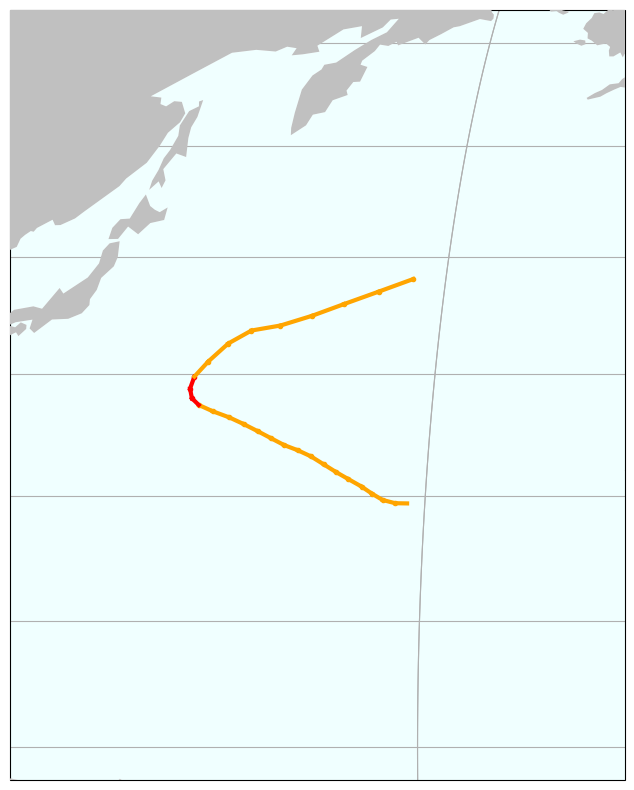

In [27]:
plot_storm_track(storm, area, itc, path_proj)

<div class="alert-warning">
<b>Info:</b> Plot Swath for Hs and Tp
</div>

<style>
.alert-warning {
    background-color: #ffe4e1; /* Color de fondo rosita claro */
    color: #c71585; /* Color del texto rosa fuerte */
    padding: 10px;
    border-radius: 5px;
    border: 1px solid #ffb6c1; /* Borde rosa claro */
}
</style>

Hs

WMO


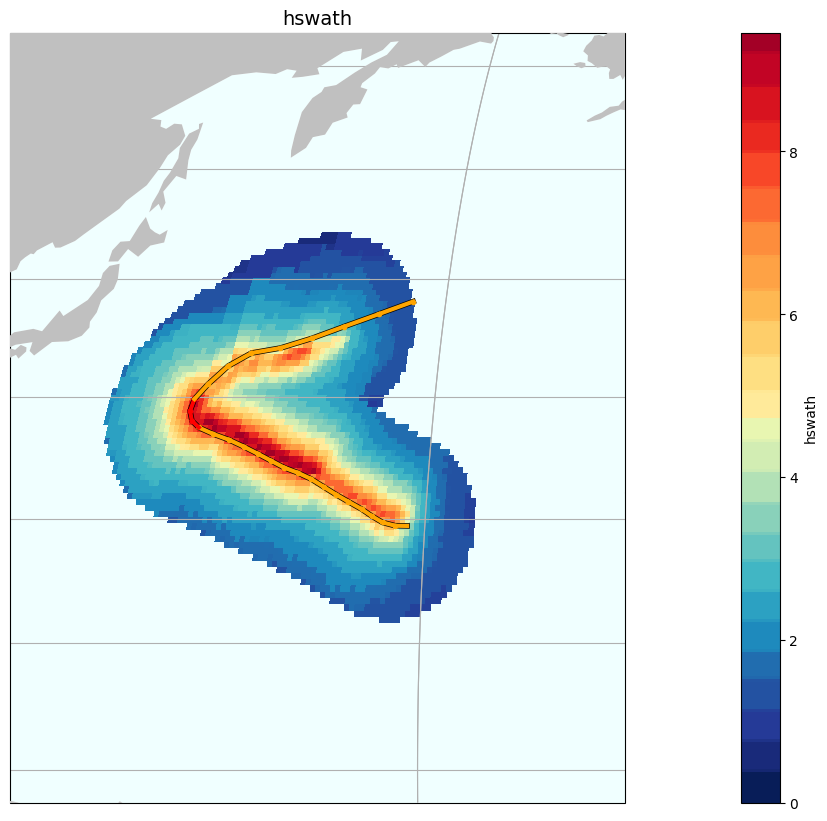

In [28]:
plot_swath_shytcwaves(storm, xds_bulk, area, itc, path_proj, var="hswath", vmax=None)

Tp

WMO


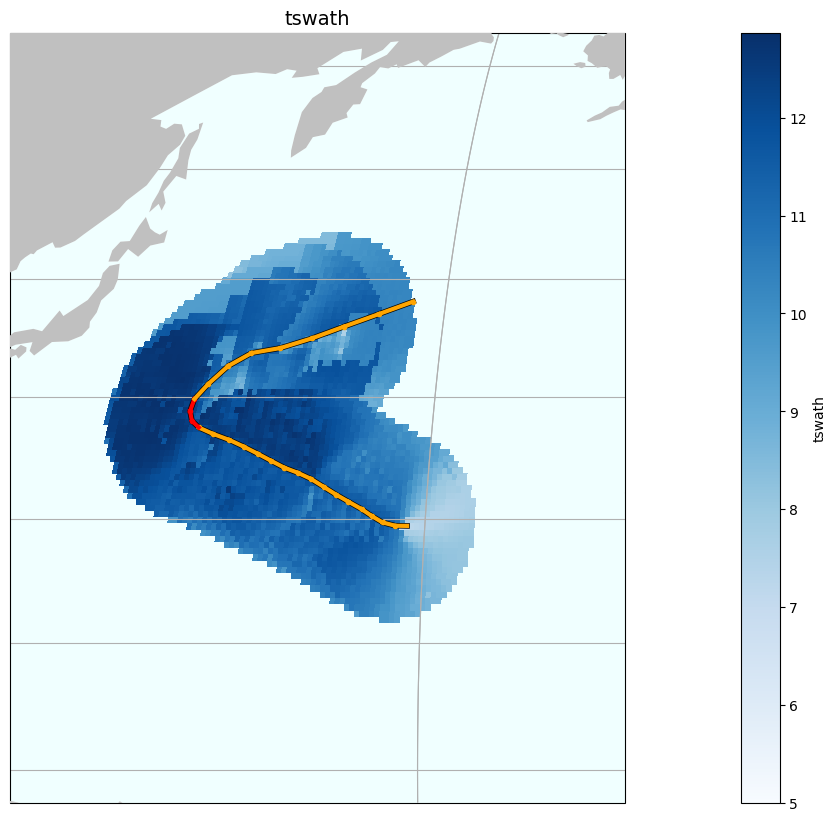

In [29]:
plot_swath_shytcwaves(
    storm, xds_bulk, area, itc, path_proj, var="tswath", vmin=5, vmax=None, cmap="Blues"
)

<div class="alert-warning">
<b>Info:</b> Plot Time evolution of Hs and Tp in a selected point
</div>

<style>
.alert-warning {
    background-color: #ffe4e1; /* Color de fondo rosita claro */
    color: #c71585; /* Color del texto rosa fuerte */
    padding: 10px;
    border-radius: 5px;
    border: 1px solid #ffb6c1; /* Borde rosa claro */
}
</style>

In [40]:
lon, lat = 150, 31

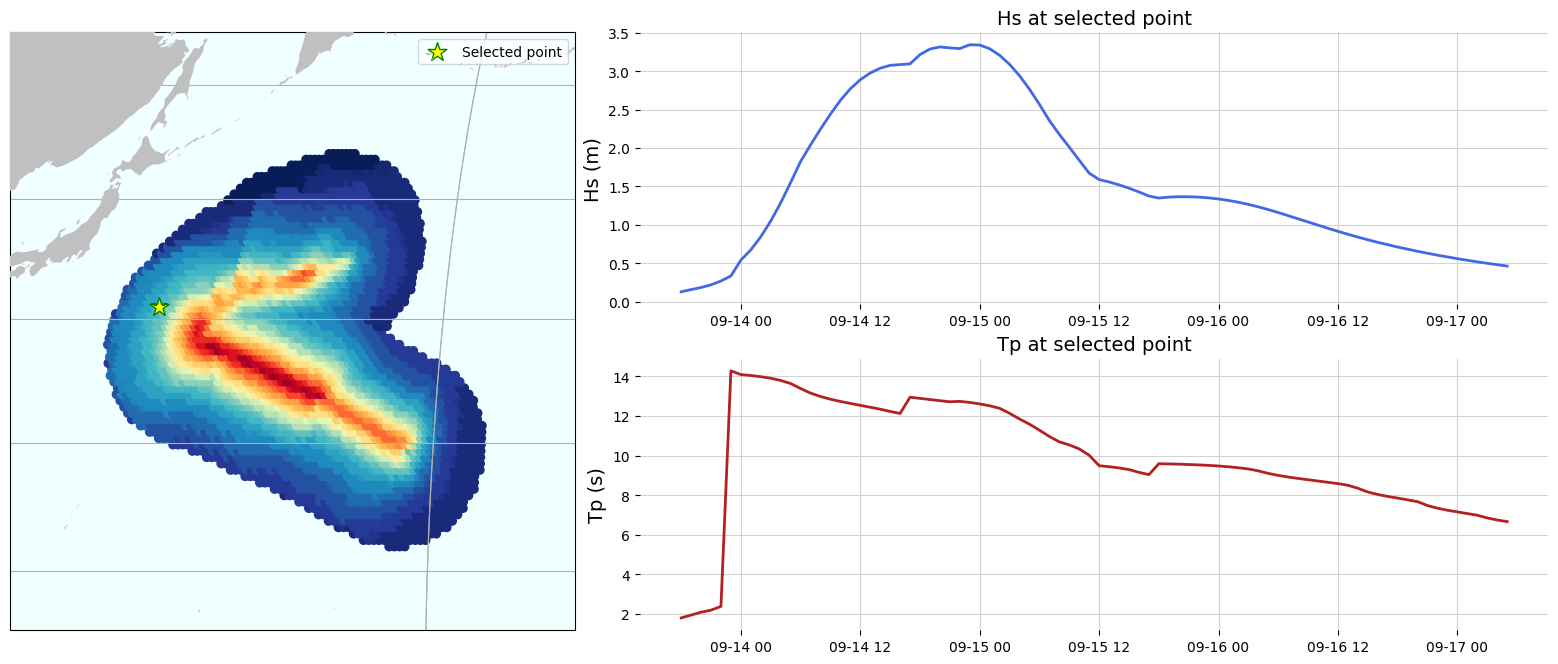

In [41]:
plot_hs_tp_point(xds_bulk, area, lon, lat)